 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Untitled.ipynb?kernel_name=python3#Convert-input-data" data-toc-modified-id="Convert-input-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Convert input data</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Untitled.ipynb?kernel_name=python3#Convert-to-categorical-output" data-toc-modified-id="Convert-to-categorical-output-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Convert to categorical output</a></span></li></ul></li></ul></div>

# Categorical/binned output 

In [54]:
# Imports
from importlib import reload
import utils; reload(utils)
from utils import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Dropout
from keras.layers.merge import Concatenate
from keras.models import Model
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam

Anaconda environment: py36_keras
Darwin 17.0.0


In [2]:
# Setup
DATA_DIR = '/Volumes/STICK/data/ppnn_data/'  # Mac
fclt = 48

## Convert input data

In [5]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates)

train set contains 365 days
test set contains 366 days


In [8]:
train_set.targets.shape, train_set.targets[:5]

((180849,),
 array([ 2.20000005, -3.70000005, -2.0999999 ,  1.60000002,  0.60000002], dtype=float32))

In [12]:
test_set.targets.min(), test_set.targets.max()

(-23.299999, 27.299999)

In [13]:
train_set.targets.min(), train_set.targets.max()

(-21.4, 29.299999)

In [84]:
bin_width = 0.5
bin_edges = np.arange(-30, 35 + bin_width, bin_width)
bin_edges.shape

(131,)

### Convert to categorical output

In [17]:
from scipy.stats import binned_statistic

In [22]:
import keras
import keras.backend as K
import theano.tensor as T

In [107]:
# Assing closest value
train_set.targets.shape

(180849,)

In [111]:
np.argmin(np.abs(bin_edges - train_set.targets[0]))

64

In [112]:
binned_statistic(train_set.targets[0], train_set.targets[0], bins=bin_edges)[-1]

array([65])

In [113]:
train_set.targets[0]

2.2

In [115]:
bin_edges[64:66]

array([ 2. ,  2.5])

In [120]:
a = np.repeat(np.atleast_2d(bin_edges), train_set.targets.shape[0], axis=0).T

In [125]:
np.argmin(np.abs(a - train_set.targets),axis=0).shape

(180849,)

In [26]:
def convert_targets(targets, bin_edges):
    bin_idxs = binned_statistic(targets, targets, bins=bin_edges)[-1]
    return keras.utils.to_categorical(bin_idxs, num_classes=bin_edges.shape[0]-1)

In [85]:
train_cat_targets = convert_targets(train_set.targets, bin_edges)
test_cat_targets = convert_targets(test_set.targets, bin_edges)

In [75]:
def approx_crps(y_true, y_pred):
    # [sample, cat]
    cum_obs = K.cumsum(y_true, axis=1)
    cum_preds = K.cumsum(y_pred, axis=1)
    approx_crps = K.sum(K.square(cum_obs - cum_preds), axis=1) * bin_width
    approx_crps = K.mean(approx_crps)
    return approx_crps

In [99]:
inp = Input(shape=(2,))
x = Dense(50, activation='relu')(inp)
x = Dense(50, activation='relu')(x)
x = Dense(bin_edges.shape[0]-1, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)

In [100]:
model.compile(optimizer=Adam(0.01), loss=approx_crps)

In [101]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_29 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_30 (Dense)             (None, 130)               6630      
Total params: 9,330
Trainable params: 9,330
Non-trainable params: 0
_________________________________________________________________


In [102]:
model.fit(train_set.features, train_cat_targets, epochs=5, batch_size=4096,
          validation_data=[test_set.features, test_cat_targets])

Train on 180849 samples, validate on 182218 samples
Epoch 1/5
180849/180849 [==============================] - 5s - loss: 2.6314 - val_loss: 1.2667
Epoch 2/5
180849/180849 [==============================] - 5s - loss: 1.1491 - val_loss: 1.0848
Epoch 3/5
180849/180849 [==============================] - 5s - loss: 1.0894 - val_loss: 1.0520
Epoch 4/5
180849/180849 [==============================] - 5s - loss: 1.0793 - val_loss: 1.0692
Epoch 5/5
180849/180849 [==============================] - 5s - loss: 1.0772 - val_loss: 1.0384


In [103]:
preds = model.predict(test_set.features)

In [104]:
preds.shape

(182218, 130)

In [105]:
i = 40001

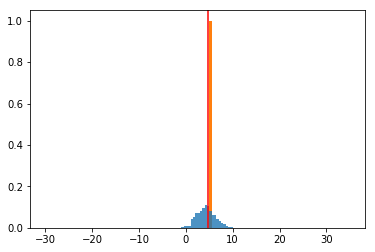

In [106]:
plt.bar(bin_edges[:-1] + 0.25, preds[i], width=0.5, alpha=0.8)
plt.bar(bin_edges[:-1] + 0.25, test_cat_targets[i], width=0.5, zorder=0.1)
plt.axvline(test_set.targets[i], c='r')
plt.show()